In [171]:
import pandas as pd
import numpy
import numpy as np

# For modeling the stocks
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, RobustScaler, QuantileTransformer

import matplotlib.pyplot as plt
from scipy.stats import norm, probplot, t

# Import dart APIs
from darts import TimeSeries
from darts.models import RNNModel, TFTModel, MovingAverage
from darts.utils.likelihood_models import GaussianLikelihood, QuantileRegression
from darts.dataprocessing.transformers import Scaler
from darts.dataprocessing import Pipeline
from darts.metrics import mape, mse, r2_score
from darts.utils.losses import MAELoss, MapeLoss
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import Callback
from torch.nn import MSELoss

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# For time stamps
from datetime import datetime, timedelta

plt.style.use("fivethirtyeight")
%matplotlib inline



### Predicting the closing price of Bitcoin:

### Checking Data

In [172]:
# Get the stock quote
df = pd.read_csv('BTCUSDT_Binance_futures_data_hour.csv', parse_dates = True, index_col = 'date', usecols=['date', 'open', 'high', 'low', 'close', 'Volume USDT'])
#invert dataframes and sort by dates
df = df.reindex(index=df.index[::-1])

# Show the data
df

,open,high,low,close,Volume USDT
date,,,,,
2020-08-02 02:00:00,11956.28,11980.00,11904.86,11940.59,1.697627e+08
2020-08-02 03:00:00,11940.59,12037.99,11885.00,12026.41,1.919961e+08
2020-08-02 04:00:00,12026.41,12154.25,10490.00,11185.00,1.541747e+09
2020-08-02 05:00:00,11185.00,11422.46,11126.90,11260.00,5.431858e+08
2020-08-02 06:00:00,11260.00,11328.14,11215.00,11302.34,1.499471e+08
...,...,...,...,...,...
2022-08-24 20:00:00,21695.90,21750.00,21666.60,21676.00,2.230968e+08
2022-08-24 21:00:00,21676.10,21711.30,21520.00,21584.50,2.588562e+08
2022-08-24 22:00:00,21584.60,21646.40,21444.00,21483.40,5.783874e+08


In [173]:
# Checking data
df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
df.isna().sum()

Open           0
High           0
Low            0
Close          0
Volume USDT    0
dtype: int64

In [174]:
# remove timezone
df.index = df.index.tz_localize(None)
df

,Open,High,Low,Close,Volume USDT
date,,,,,
2020-08-02 02:00:00,11956.28,11980.00,11904.86,11940.59,1.697627e+08
2020-08-02 03:00:00,11940.59,12037.99,11885.00,12026.41,1.919961e+08
2020-08-02 04:00:00,12026.41,12154.25,10490.00,11185.00,1.541747e+09
2020-08-02 05:00:00,11185.00,11422.46,11126.90,11260.00,5.431858e+08
2020-08-02 06:00:00,11260.00,11328.14,11215.00,11302.34,1.499471e+08
...,...,...,...,...,...
2022-08-24 20:00:00,21695.90,21750.00,21666.60,21676.00,2.230968e+08
2022-08-24 21:00:00,21676.10,21711.30,21520.00,21584.50,2.588562e+08
2022-08-24 22:00:00,21584.60,21646.40,21444.00,21483.40,5.783874e+08


In [175]:
# Slicing data for faster training
# Slicing rows in data frame
#df = df.loc['2022-6-1':]

# data frame after slicing
df

,Open,High,Low,Close,Volume USDT
date,,,,,
2020-08-02 02:00:00,11956.28,11980.00,11904.86,11940.59,1.697627e+08
2020-08-02 03:00:00,11940.59,12037.99,11885.00,12026.41,1.919961e+08
2020-08-02 04:00:00,12026.41,12154.25,10490.00,11185.00,1.541747e+09
2020-08-02 05:00:00,11185.00,11422.46,11126.90,11260.00,5.431858e+08
2020-08-02 06:00:00,11260.00,11328.14,11215.00,11302.34,1.499471e+08
...,...,...,...,...,...
2022-08-24 20:00:00,21695.90,21750.00,21666.60,21676.00,2.230968e+08
2022-08-24 21:00:00,21676.10,21711.30,21520.00,21584.50,2.588562e+08
2022-08-24 22:00:00,21584.60,21646.40,21444.00,21483.40,5.783874e+08


In [176]:
df['Return'] = df['Close'].pct_change()
df

,Open,High,Low,Close,Volume USDT,Return
date,,,,,,
2020-08-02 02:00:00,11956.28,11980.00,11904.86,11940.59,1.697627e+08,NaN
2020-08-02 03:00:00,11940.59,12037.99,11885.00,12026.41,1.919961e+08,0.007187
2020-08-02 04:00:00,12026.41,12154.25,10490.00,11185.00,1.541747e+09,-0.069964
2020-08-02 05:00:00,11185.00,11422.46,11126.90,11260.00,5.431858e+08,0.006705
2020-08-02 06:00:00,11260.00,11328.14,11215.00,11302.34,1.499471e+08,0.003760
...,...,...,...,...,...,...
2022-08-24 20:00:00,21695.90,21750.00,21666.60,21676.00,2.230968e+08,-0.000913
2022-08-24 21:00:00,21676.10,21711.30,21520.00,21584.50,2.588562e+08,-0.004221
2022-08-24 22:00:00,21584.60,21646.40,21444.00,21483.40,5.783874e+08,-0.004684


In [177]:
# Checking data
df.isna().sum()
# first row has a NA return. I set it to 0 manually
df = df.fillna(0)
df.isna().sum()

Open           0
High           0
Low            0
Close          0
Volume USDT    0
Return         0
dtype: int64

In [178]:
# Creating a new feature about price

low_low=[]

for row in range(len(df)):
    if df.iloc[row-1, 2] > df.iloc[row, 2]:
        low_low.append(0)
        
    elif (df.iloc[row-1, 2] < df.iloc[row, 2]):
        low_low.append(1)
        
    elif (df.iloc[row-1, 2] == df.iloc[row, 2]):
        low_low.append(-1)
        
low_low = np.array(low_low)        
low_low = np.transpose(low_low).reshape(-1,1)
df['Custom lows'] = low_low
df

,Open,High,Low,Close,Volume USDT,Return,Custom lows
date,,,,,,,
2020-08-02 02:00:00,11956.28,11980.00,11904.86,11940.59,1.697627e+08,0.000000,0
2020-08-02 03:00:00,11940.59,12037.99,11885.00,12026.41,1.919961e+08,0.007187,0
2020-08-02 04:00:00,12026.41,12154.25,10490.00,11185.00,1.541747e+09,-0.069964,0
2020-08-02 05:00:00,11185.00,11422.46,11126.90,11260.00,5.431858e+08,0.006705,1
2020-08-02 06:00:00,11260.00,11328.14,11215.00,11302.34,1.499471e+08,0.003760,1
...,...,...,...,...,...,...,...
2022-08-24 20:00:00,21695.90,21750.00,21666.60,21676.00,2.230968e+08,-0.000913,1
2022-08-24 21:00:00,21676.10,21711.30,21520.00,21584.50,2.588562e+08,-0.004221,0
2022-08-24 22:00:00,21584.60,21646.40,21444.00,21483.40,5.783874e+08,-0.004684,0


In [179]:
# Creating a new feature about price

high_high=[]

for row in range(len(df)):
    if df.iloc[row-1, 1] > df.iloc[row, 1]:
        high_high.append(0)
        
    elif (df.iloc[row-1, 1] < df.iloc[row, 1]):
        high_high.append(1)
        
    elif (df.iloc[row-1, 1] == df.iloc[row, 1]):
        high_high.append(-1)
        
high_high = np.array(high_high)        
high_high = np.transpose(high_high).reshape(-1,1)
df['Custom highs'] = high_high
df

,Open,High,Low,Close,Volume USDT,Return,Custom lows,Custom highs
date,,,,,,,,
2020-08-02 02:00:00,11956.28,11980.00,11904.86,11940.59,1.697627e+08,0.000000,0,0
2020-08-02 03:00:00,11940.59,12037.99,11885.00,12026.41,1.919961e+08,0.007187,0,1
2020-08-02 04:00:00,12026.41,12154.25,10490.00,11185.00,1.541747e+09,-0.069964,0,1
2020-08-02 05:00:00,11185.00,11422.46,11126.90,11260.00,5.431858e+08,0.006705,1,0
2020-08-02 06:00:00,11260.00,11328.14,11215.00,11302.34,1.499471e+08,0.003760,1,0
...,...,...,...,...,...,...,...,...
2022-08-24 20:00:00,21695.90,21750.00,21666.60,21676.00,2.230968e+08,-0.000913,1,0
2022-08-24 21:00:00,21676.10,21711.30,21520.00,21584.50,2.588562e+08,-0.004221,0,0
2022-08-24 22:00:00,21584.60,21646.40,21444.00,21483.40,5.783874e+08,-0.004684,0,0


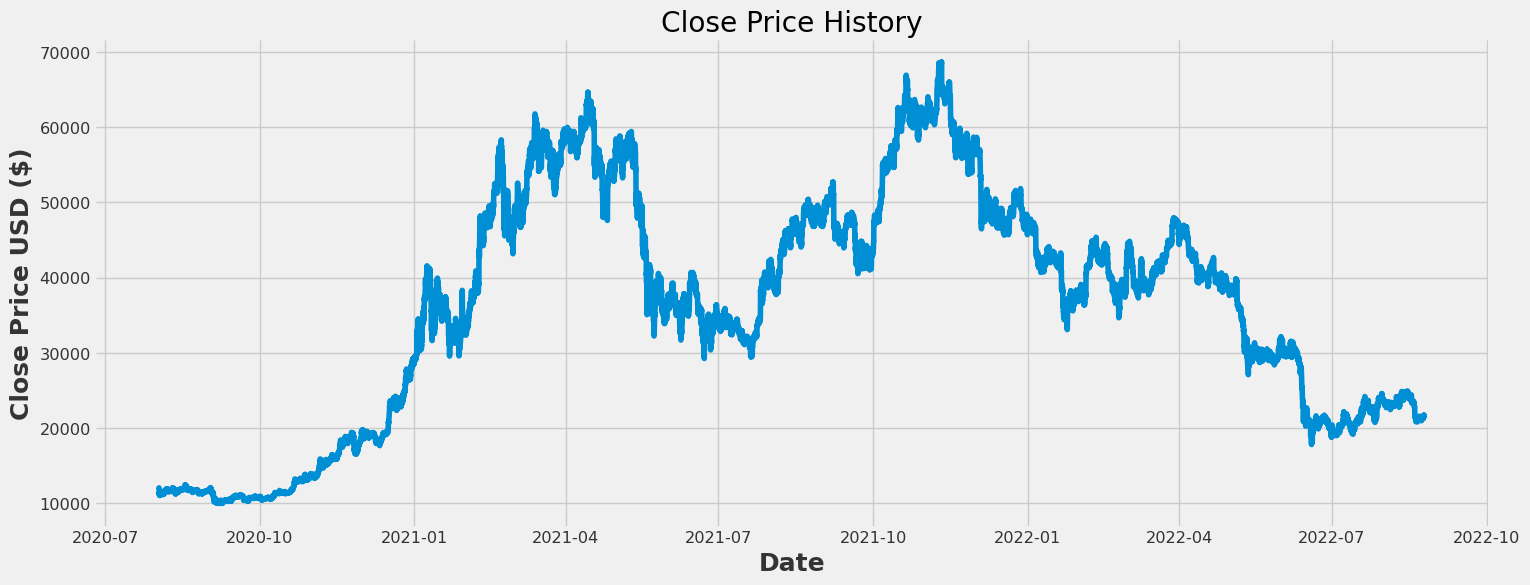

In [180]:
# Plot close price history
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
#plt.hist(df['Volume']);
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

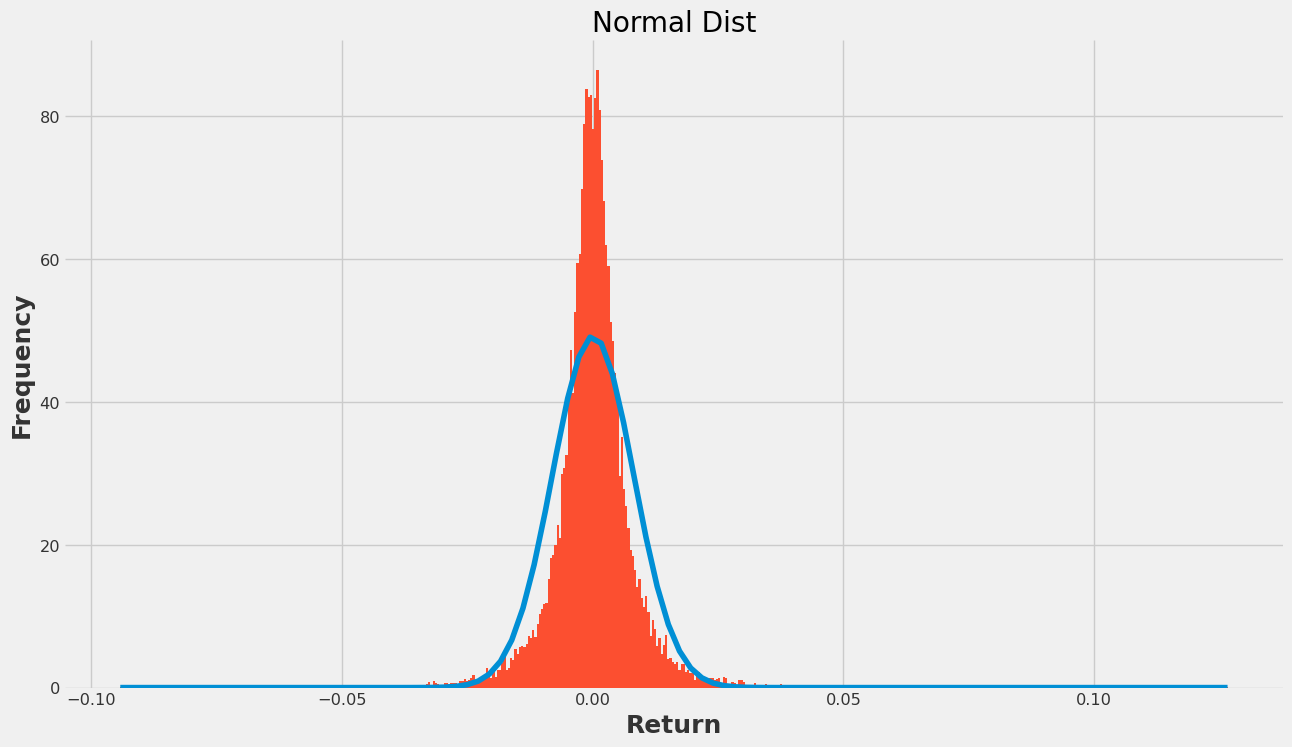

In [181]:
x_list = np.linspace(
                    df['Return'].min(),
                    df['Return'].max(),
                    100
                    )

y_list = norm.pdf(x_list, loc=df['Return'].mean(), scale=df['Return'].std())

plt.figure(figsize=(14,8))
plt.title('Normal Dist')
plt.xlabel('Return', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.plot(x_list,y_list);
plt.hist(df['Return'], bins=500,density=True);

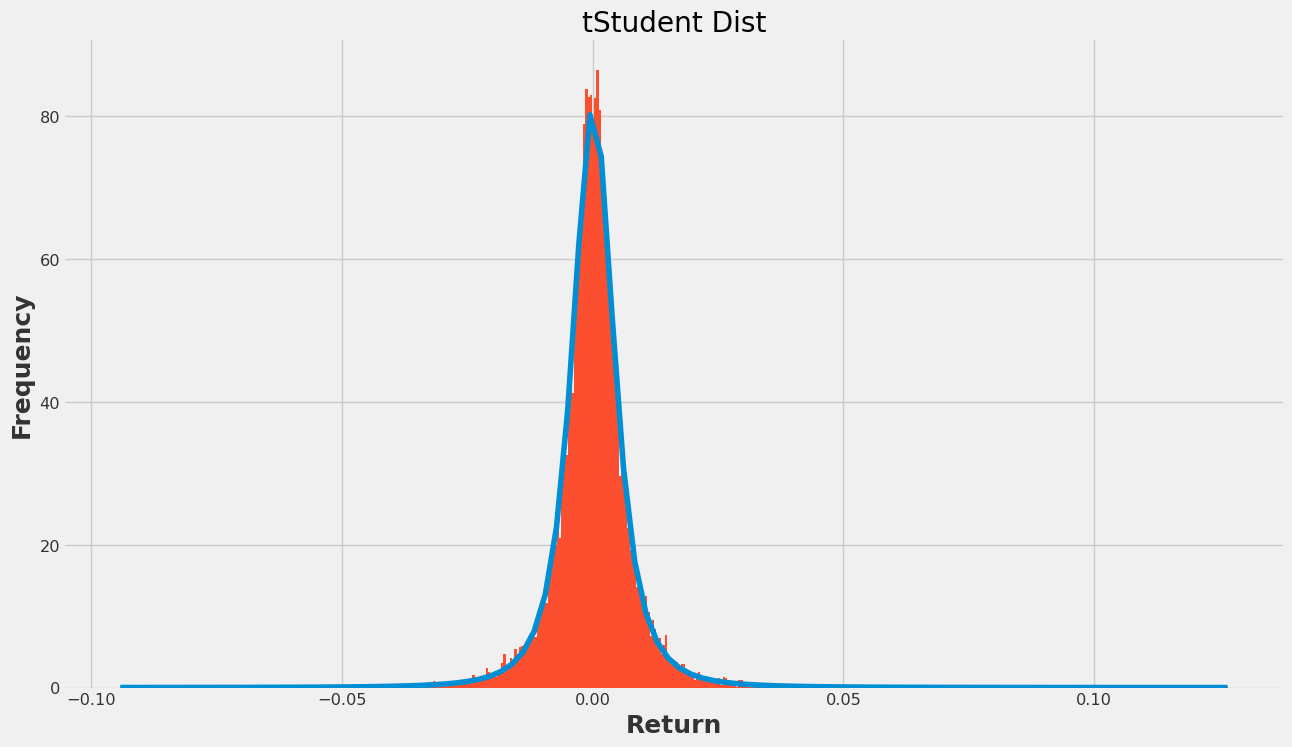

In [182]:
x_list = np.linspace(
                    df['Return'].min(),
                    df['Return'].max(),
                    100
                    )

params = t.fit(df['Return'].dropna())
degree_of_freedom, loc, scale = params

y_list = t.pdf(x_list, degree_of_freedom, loc, scale)

plt.figure(figsize=(14,8))
plt.title('tStudent Dist')
plt.xlabel('Return', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.plot(x_list,y_list);
plt.hist(df['Return'], bins=500,density=True);

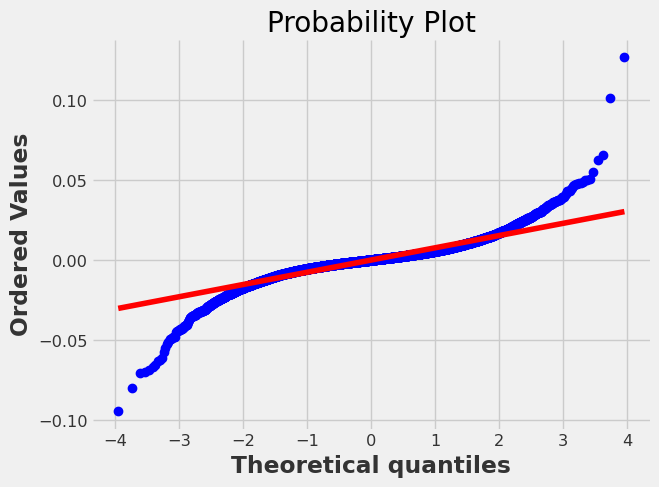

In [183]:
probplot(df['Return'],dist='norm',fit= True,plot=plt);

### Processing data

In [184]:
# features list
features = ['Close']
feature_size = len(features)
feature_size

1

In [185]:
# Create a new dataframe with only the 'Close' and 'volume' column 
df = df.filter(features)
print(type(df))
df

<class 'pandas.core.frame.DataFrame'>


,Close
date,
2020-08-02 02:00:00,11940.59
2020-08-02 03:00:00,12026.41
2020-08-02 04:00:00,11185.00
2020-08-02 05:00:00,11260.00
2020-08-02 06:00:00,11302.34
...,...
2022-08-24 20:00:00,21676.00
2022-08-24 21:00:00,21584.50
2022-08-24 22:00:00,21483.40


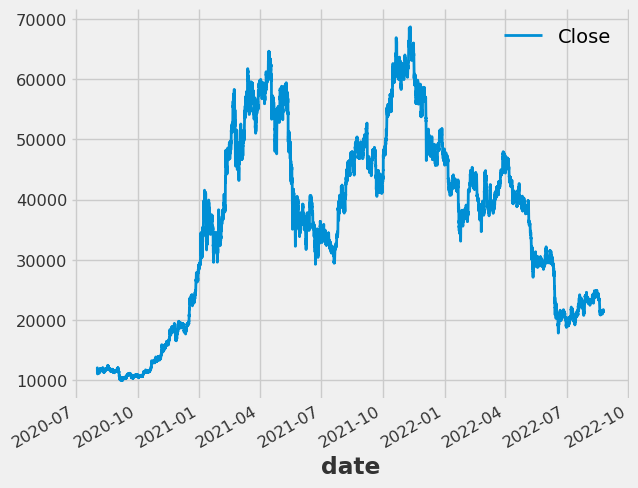

In [186]:
#bh = pd.tseries.offsets.BusinessHour(start='9:30', end='15:30')
data = TimeSeries.from_dataframe(df, fill_missing_dates=True, freq='H')
data.plot()

### Smoothing data

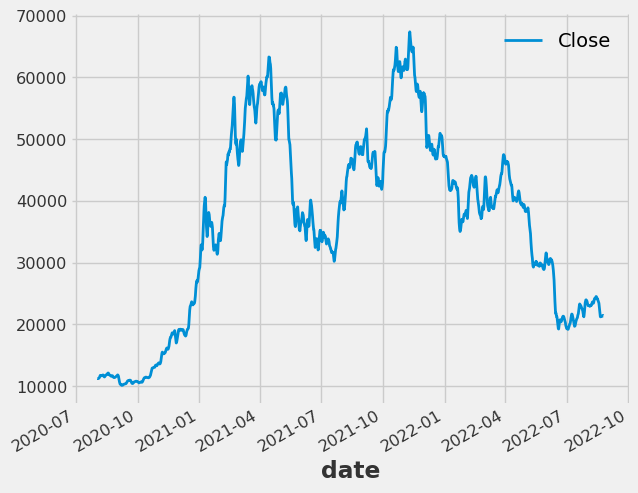

In [187]:
moving = MovingAverage(window=48)
data = moving.filter(data)
data.plot()

In [188]:
# Get the number of rows to train the model on (90% of total data)
x_train, x_test = data.split_before(0.9)
print(x_train.n_timesteps)
print(x_test.n_timesteps)

16263
1808


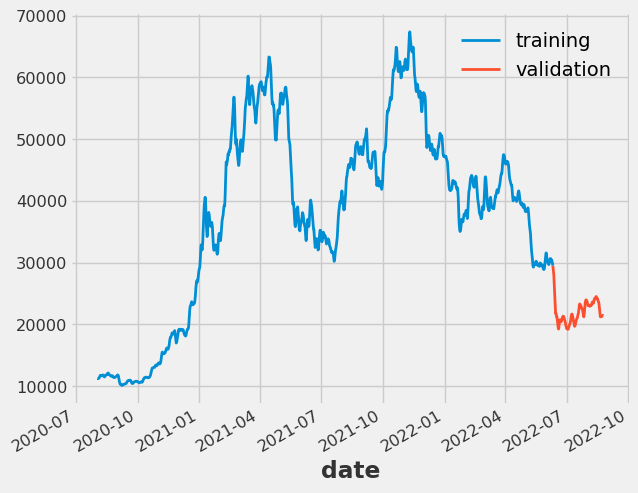

In [189]:
x_train.plot(label="training")
x_test.plot(label="validation")

### Transform data with pipeline

In [190]:
# Pipeline
scaler1 = RobustScaler()
scaler2 = MinMaxScaler()
pipeline = Pipeline([Scaler(scaler1),  Scaler(scaler2)])
rescaled_train = pipeline.fit_transform(x_train)
rescaled_test = pipeline.transform(x_test)
rescaled_data = pipeline.transform(data)

In [191]:
print('All data end time: ' + str(rescaled_data.end_time()))
print('Train data end time: ' + str(rescaled_train.end_time()))
print('Test data end time: ' + str(rescaled_test.end_time()))

All data end time: 2022-08-25 00:00:00
Train data end time: 2022-06-10 16:00:00
Test data end time: 2022-08-25 00:00:00


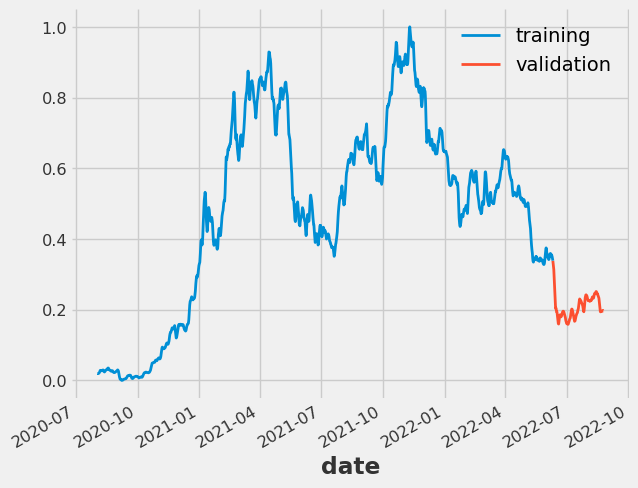

In [192]:
rescaled_train.plot(label="training")
rescaled_test.plot(label="validation")

### Building Model using Temporal Fusion Transformer (TFT)

#### Callbacks

In [193]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pl_bolts.callbacks import PrintTableMetricsCallback

# stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
# a period of 5 epochs (`patience`)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=0.005,
    mode='min',
)

# saves a file like: my/path/epoch=2-val_loss=0.02-other_metric=0.03.ckpt
model_checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                            save_top_k=5,
                                            dirpath='saved_model',
                                            filename='{epoch}-{val_loss:.2f}-{other_metric:.2f}',
                                            )

lr_monitor = LearningRateMonitor(logging_interval='step')

metric_callback = PrintTableMetricsCallback()

### Create covariate

In [194]:
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# create year, month and integer index covariate series
training_cutoff = pd.Timestamp(rescaled_train.end_time())
covariates = datetime_attribute_timeseries(data, attribute='day', one_hot=False)
covariates = covariates.stack(
    datetime_attribute_timeseries(data, attribute='hour', one_hot=False)
)


covariates = covariates.stack(
    TimeSeries.from_times_and_values(
        times=data.time_index,
        values=np.arange(len(data)),
        columns=['linear_increase'],
    )
)
covariates = covariates.astype(np.float32)

# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

In [195]:
covariates.to_csv('cov.csv')

In [196]:
encoders={
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['hour', 'dayofweek']},
    'position': {'past': ['absolute'], 'future': ['relative']},
    'custom': {'past': [lambda idx: (idx.year - 1950) / 50]},
    'transformer': Scaler()
}

# default quantiles for QuantileRegression
quantiles = [0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5,0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.99]
input_chunk_length = 60
forecast_horizon = 15
tft_model = TFTModel(
    model_name='TFTModel',
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=100,
    lstm_layers=1,
    num_attention_heads=8,
    dropout=0,
    batch_size=160,
    n_epochs=20,
    add_relative_index=False,
    #add_encoders=encoders,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    #loss_fn=MAELoss(),
    pl_trainer_kwargs={'callbacks': [early_stopping_callback]},
    force_reset=True,
    save_checkpoints=True,
    log_tensorboard=True,
)

In [197]:
model = tft_model.fit(rescaled_train, val_series=rescaled_test, future_covariates=covariates_transformed, val_future_covariates=covariates_transformed, verbose=True)

C:\Users\HKamkar\.conda\envs\darts\lib\site-packages\darts\timeseries.py:4079: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
2022-08-26 15:35:49 pytorch_lightning.utilities.distributed INFO: GPU available: False, used: False
2022-08-26 15:35:49 pytorch_lightning.utilities.distributed INFO: TPU available: False, using: 0 TPU cores
2022-08-26 15:35:49 pytorch_lightning.utilities.distributed INFO: IPU available: False, using: 0 IPUs
2022-08-26 15:35:50 pytorch_lightning.callbacks.model_summary INFO: 
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [198]:
# load the model state that performed best on validation set
best_model = model.load_from_checkpoint(model_name='TFTModel', best=True)

In [199]:
# before starting, we define some constants
num_samples = 100

figsize = (10, 6)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [211]:
def eval_model(model_name, forecast_horizon, actual_series, val_series):
    pred_series = model.predict(n=forecast_horizon, num_samples=num_samples, future_covariates=covariates_transformed, mc_dropout=True)

    # Rescale data to real value (Inverse transform)
    pred_series = pipeline.inverse_transform(pred_series)
    actual_series = pipeline.inverse_transform(actual_series)
    val_series = pipeline.inverse_transform(val_series)

    # plot actual series
    plt.figure(figsize=figsize)
    end = pred_series.end_time()
    start = end - timedelta(days=2)
    actual_series[start : end].plot(label="actual")

    # plot prediction with quantile ranges
    pred_series.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer)
    pred_series.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

    # Plot title
    plt.title('MAPE: {:.2f}%'.format(mape(val_series, pred_series)))
    plt.legend()

Predicting: 102it [00:00, ?it/s]

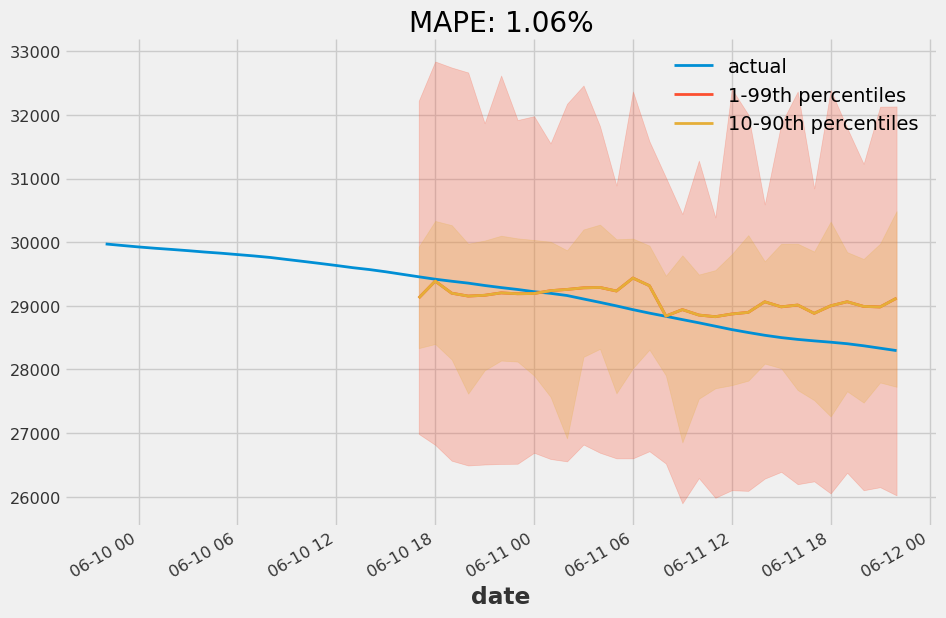

In [212]:
prediction = eval_model(best_model, 30, rescaled_data, rescaled_test)